In [70]:
import sys
sys.path.append('../scripts')
from data_preparation import load_data, convert_datatypes, handle_missing_values, drop_columns, remove_negative_values, calculate_zscore
from eda import load_data, convert_datatypes, resample_data_h, resample_data_m

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import zscore
from windrose import WindroseAxes
plt.style.use('ggplot')

In [72]:
df = load_data('../../data/benin-malanville.csv') 

### Step 1 - Understand the Data

In [73]:
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [74]:
df.dtypes

Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object

### Step 2 - Clean and Prepare Data 

##### Change datatypes to appropriate formats
In the previous step, the Timestamp colum has a data type of Object. So, here it's changed to date time format.

In [75]:
#convert_datatypes(df)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
print("Data Type for Timestamp -",df['Timestamp'].dtypes)
df.head()

Data Type for Timestamp - datetime64[ns]


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


Now, let's check for missing values

In [76]:
#handle_missing_values(df)
print(df.isnull().sum())

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64


Here we can see that all columns except 'Comments' have non-null values. But the 'Comments' column has null values entirely. So we can go ahead and drop it.

In [77]:
#drop_columns(df)
df = df.drop(['Comments'], axis= 1).copy()
df.shape

(525600, 18)

Now let's look for duplicate values.


In [78]:
print(df.duplicated().sum())

0


We don't have duplicates, so let's move on to handling negative values. The three solar radiation columns, GHI, DNI, DHI have consistent negative values throughout the days. When we take a closer look at the data, there's a direct correlation between these values and night time. And since we're analyzing solar radiation data, we can drop the rows recorded at night or with negative values.

In [79]:
# remove_negative_values(df)
df = df[(df['GHI'] >= 0) & (df['DNI'] >= 0) & (df['DHI'] >= 0)]
df.head(5)

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
413,2021-08-09 06:54:00,16.7,0.0,16.5,16.1,16.3,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.2,23.7
414,2021-08-09 06:55:00,18.2,0.1,18.0,17.4,17.6,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.3,23.8
415,2021-08-09 06:56:00,19.7,0.3,19.5,18.7,18.9,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.3,23.9
416,2021-08-09 06:57:00,21.1,0.6,20.9,19.9,20.1,24.2,98.9,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.4,23.9
417,2021-08-09 06:58:00,22.5,1.1,22.2,21.1,21.3,24.2,98.9,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.5,24.0


Let's reset the index since the negative values were removed.

#### Z-Score Analysis

Now, let's move on to outliers. Outliers can be calculated using Z-Score. A Z-Score measures how many standard deviations a data point is from the mean of the dataset. Here we can exclude the Timestamp column because it is consistent and calculating it's Z-Score issues a performance warning due to Adding/subtracting object-dtype array to DatetimeArray not being vectorized.

In [80]:
df_for_zscore = df.drop(['Timestamp'], axis= 1).copy()
df_for_zscore.head()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
413,16.7,0.0,16.5,16.1,16.3,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.2,23.7
414,18.2,0.1,18.0,17.4,17.6,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.3,23.8
415,19.7,0.3,19.5,18.7,18.9,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.3,23.9
416,21.1,0.6,20.9,19.9,20.1,24.2,98.9,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.4,23.9
417,22.5,1.1,22.2,21.1,21.3,24.2,98.9,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.5,24.0


Since a z-score greater than 3 or less than -3 is considered extreme, here we're filtering outliers greater than the absolute value of 3.

In [81]:
# calculate_zscore(df)
df_zscores = (df_for_zscore - df_for_zscore.mean()) / df_for_zscore.std()
outliers = df_zscores.abs() > 3
df['Outliers'] = outliers.any(axis=1)
outlier_rows = df[df['Outliers'] == True]
print("Count of rows with outlier values -", df['Outliers'].sum())
print(outlier_rows.head(5))

Count of rows with outlier values - 7713
              Timestamp     GHI    DNI    DHI    ModA    ModB  Tamb    RH  \
633 2021-08-09 10:34:00   872.0  744.5  235.8   801.0   805.0  29.7  71.8   
778 2021-08-09 12:59:00  1088.0  379.7  688.9  1016.0  1023.0  31.7  63.1   
779 2021-08-09 13:00:00  1012.0  298.4  694.3   945.0   951.0  31.4  64.6   
780 2021-08-09 13:01:00  1028.0  308.2  700.2   967.0   973.0  31.2  64.6   
781 2021-08-09 13:02:00   930.0  210.0  702.6   869.0   874.0  31.0  65.8   

      WS  WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  \
633  4.0     6.2      1.4  207.7     12.1  999         0            0.0   
778  2.5     3.9      0.6  192.6     26.3  998         0            0.0   
779  5.1     6.4      0.8  211.1      9.6  998         0            0.0   
780  3.8     4.6      0.8  210.4     10.1  998         0            0.0   
781  3.6     4.1      0.5  208.4     14.5  998         0            0.0   

     TModA  TModB  Outliers  
633   64.2   53

Here we can visualize the outliers in a Boxplot which graphically depicts numerical data through their quartiles and can highlight outliers as points that fall outside of the 'whiskers'. 




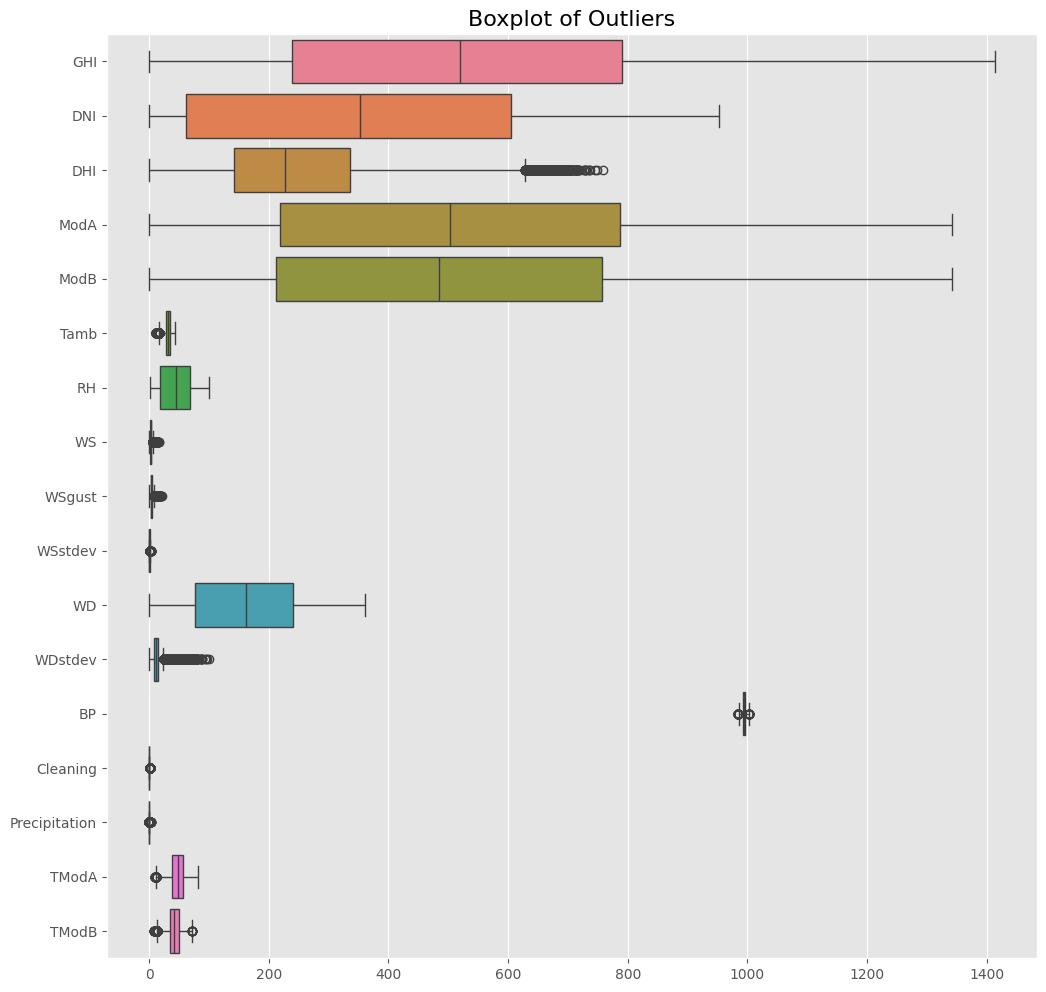

In [82]:
plt.figure(figsize=(12, 12))
sns.boxplot(data=df_for_zscore, orient='y')
plt.title('Boxplot of Outliers', fontsize=16)
plt.show()

Here we can see that columns DHI, WD, WSgust, WS have outlier values.

In [83]:
df = df.drop(['Outliers'], axis= 1).copy()
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
413,2021-08-09 06:54:00,16.7,0.0,16.5,16.1,16.3,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.2,23.7
414,2021-08-09 06:55:00,18.2,0.1,18.0,17.4,17.6,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.3,23.8
415,2021-08-09 06:56:00,19.7,0.3,19.5,18.7,18.9,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.3,23.9
416,2021-08-09 06:57:00,21.1,0.6,20.9,19.9,20.1,24.2,98.9,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.4,23.9
417,2021-08-09 06:58:00,22.5,1.1,22.2,21.1,21.3,24.2,98.9,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.5,24.0


We've gone throught the data preparation steps, now let's save our cleaned data for exploratory data analysis.

In [84]:
df.to_csv("../../data/cleaned/benin_cleaned.csv", index=False)

## Step 3 Exploratory Data Analysis

In [85]:
df = load_data('../../data/cleaned/benin_cleaned.csv')
df.head(5)

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
0,2021-08-09 06:54:00,16.7,0.0,16.5,16.1,16.3,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.2,23.7
1,2021-08-09 06:55:00,18.2,0.1,18.0,17.4,17.6,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.3,23.8
2,2021-08-09 06:56:00,19.7,0.3,19.5,18.7,18.9,24.2,98.8,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.3,23.9
3,2021-08-09 06:57:00,21.1,0.6,20.9,19.9,20.1,24.2,98.9,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.4,23.9
4,2021-08-09 06:58:00,22.5,1.1,22.2,21.1,21.3,24.2,98.9,0.0,0.0,0.0,0.0,0.0,997,0,0.0,24.5,24.0


Since we're importing a new csv file, we have to check the datatypes of the columns.

In [86]:
df.dtypes

Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
dtype: object

Timestamp colum has a data type of Object. So, it has to be changed to date time format.

In [87]:
convert_datatypes(df)

#### Summary Statistcs

In [88]:
df.describe()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
count,246878,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000,246878.000000
mean,2022-02-08 16:37:16.496002304,513.411100,356.480524,247.397346,501.775502,485.418619,31.271940,45.541173,2.802063,3.722219,0.587311,160.361394,11.926945,994.126139,0.001956,0.000860,47.396643,42.229899
min,2021-08-09 06:54:00,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.500000,8.400000
25%,2021-11-08 14:24:15,239.000000,61.200000,141.200000,218.800000,211.800000,27.700000,18.800000,1.700000,2.400000,0.400000,76.500000,8.500000,992.000000,0.000000,0.000000,38.800000,34.900000
50%,2022-02-09 13:18:30,520.300000,352.250000,227.800000,502.100000,484.900000,31.500000,44.600000,2.700000,3.600000,0.600000,161.300000,11.400000,994.000000,0.000000,0.000000,48.000000,42.400000
75%,2022-05-11 15:17:45,790.000000,605.300000,336.200000,786.400000,757.700000,35.400000,68.100000,3.800000,4.900000,0.700000,240.900000,14.700000,996.000000,0.000000,0.000000,56.500000,49.600000
max,2022-08-08 16:51:00,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,16.000000,22.300000,3.400000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000
std,NaN,304.765569,279.731019,143.420836,307.789277,298.429501,5.459802,27.015814,1.540762,1.898862,0.249724,95.546187,6.249953,2.637058,0.044188,0.030041,12.496610,10.599677


In [89]:
df.isna().sum()

Timestamp        0
GHI              0
DNI              0
DHI              0
ModA             0
ModB             0
Tamb             0
RH               0
WS               0
WSgust           0
WSstdev          0
WD               0
WDstdev          0
BP               0
Cleaning         0
Precipitation    0
TModA            0
TModB            0
dtype: int64

### Step 3: Feature Understanding

##### Visualize data distribution and frequency with Histograms 

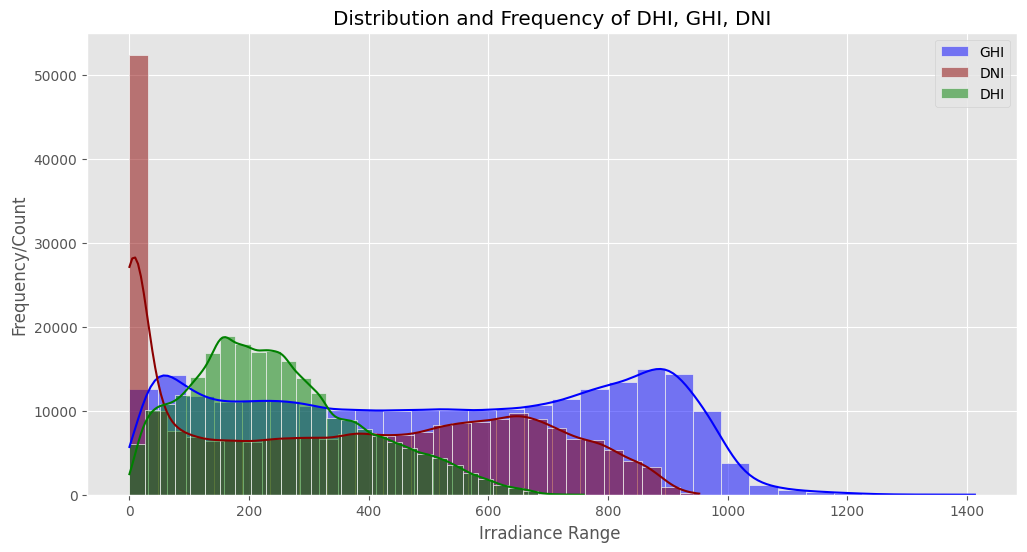

In [90]:
plt.figure(figsize=(12, 6))

sns.histplot(df['GHI'], bins=30, color='blue', label='GHI', kde=True)
sns.histplot(df['DNI'], bins=30, color='darkred', label='DNI', kde=True)
sns.histplot(df['DHI'], bins=30, color='green', label='DHI', kde=True)

plt.title('Distribution and Frequency of DHI, GHI, DNI')
plt.xlabel('Irradiance Range ')
plt.ylabel('Frequency/Count')
plt.legend()
plt.show()

#### Time Series Analysis

We can use a timeseries analysis to see trends and fluctuations over a period of time.

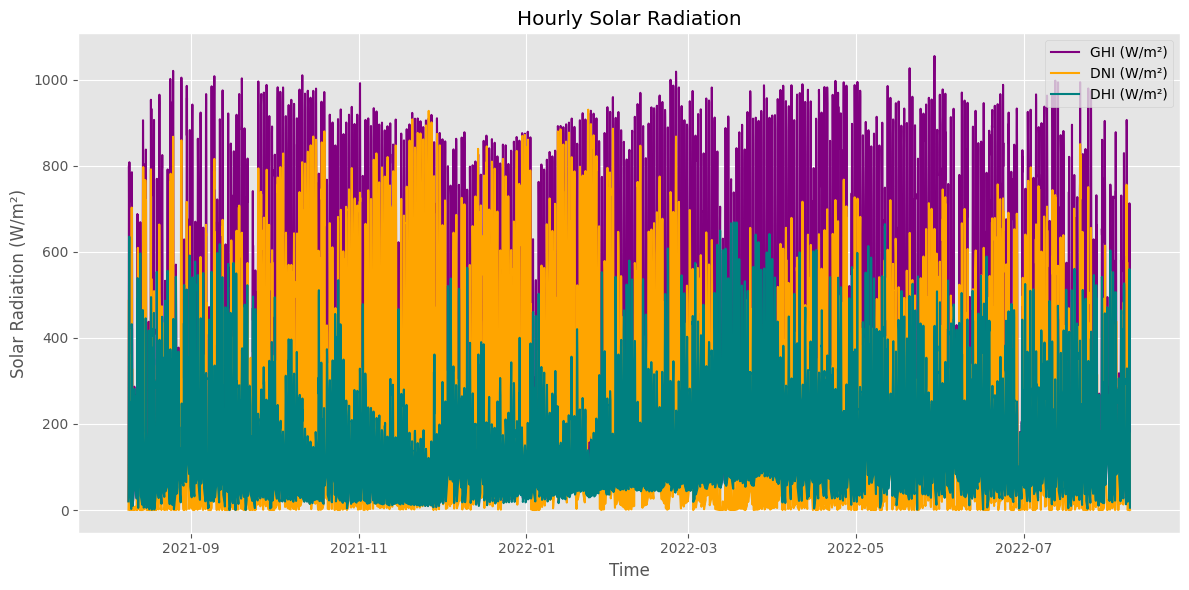

In [91]:
# Resample Timestamp by Hour
hourly_data = resample_data_h(df)

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_data, x=hourly_data.index, y='GHI', label='GHI (W/m²)', color='purple')
sns.lineplot(data=hourly_data, x=hourly_data.index, y='DNI', label='DNI (W/m²)', color='orange')
sns.lineplot(data=hourly_data, x=hourly_data.index, y='DHI', label='DHI (W/m²)', color='teal')

plt.title('Hourly Solar Radiation')
plt.xlabel('Time')
plt.ylabel('Solar Radiation (W/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

The above graph shows hourly solar radiation measures over a year with high granularity. Let's resample our data to see the monthy trends.


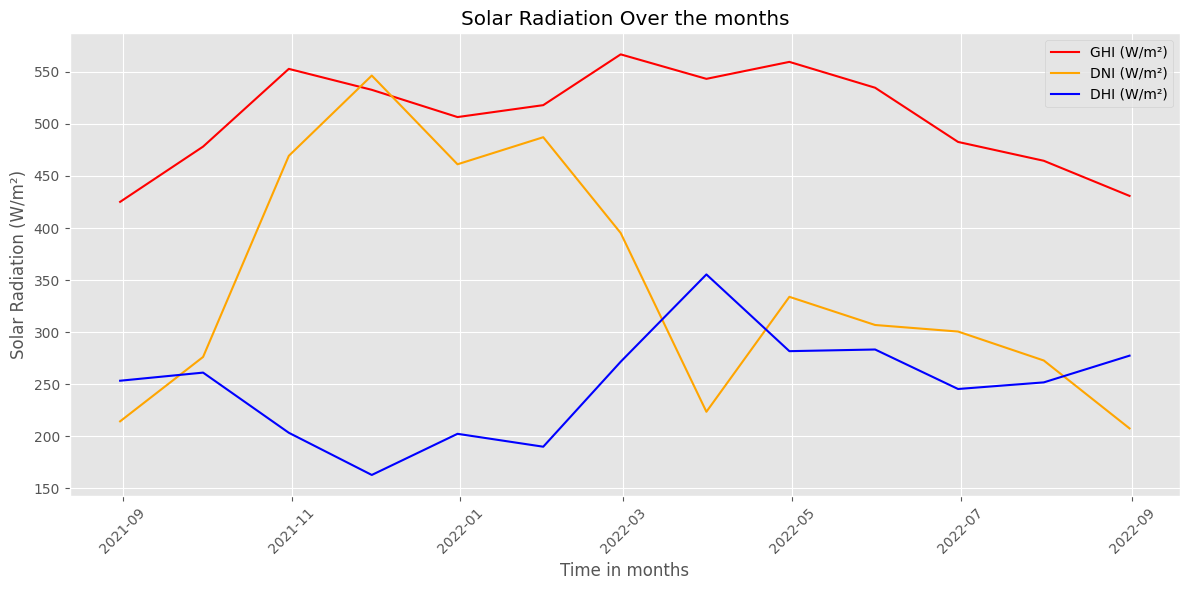

In [92]:
monthly_data = resample_data_m(df)

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_data, x=monthly_data.index, y='GHI', label='GHI (W/m²)', color='red')
sns.lineplot(data=monthly_data, x=monthly_data.index, y='DNI', label='DNI (W/m²)', color='orange')
sns.lineplot(data=monthly_data, x=monthly_data.index, y='DHI', label='DHI (W/m²)', color='blue')

plt.title('Solar Radiation Over the months')
plt.xlabel('Time in months')
plt.ylabel('Solar Radiation (W/m²)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


The previous graph shows peaks and low points in our data and an overall trend line.

Now let's plot the Ambient Temprature resampled by hours and months.

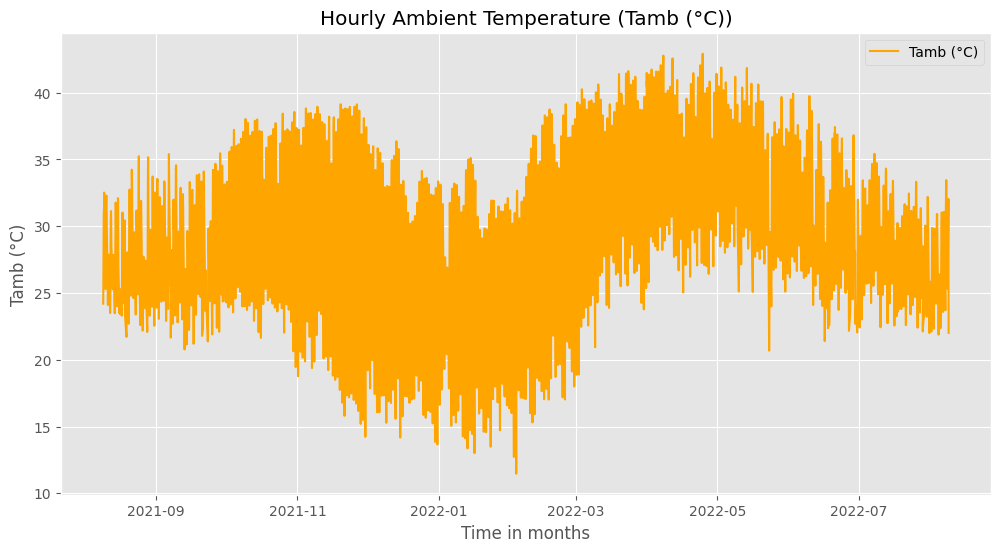

In [93]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_data, x=hourly_data.index, y='Tamb', label='Tamb (°C)', color='orange')

plt.title('Hourly Ambient Temperature (Tamb (°C))')
plt.xlabel('Time in months')
plt.ylabel('Tamb (°C)')
plt.legend()

plt.show()

##### Monthly Ambient Temperature (Tamb (°C))

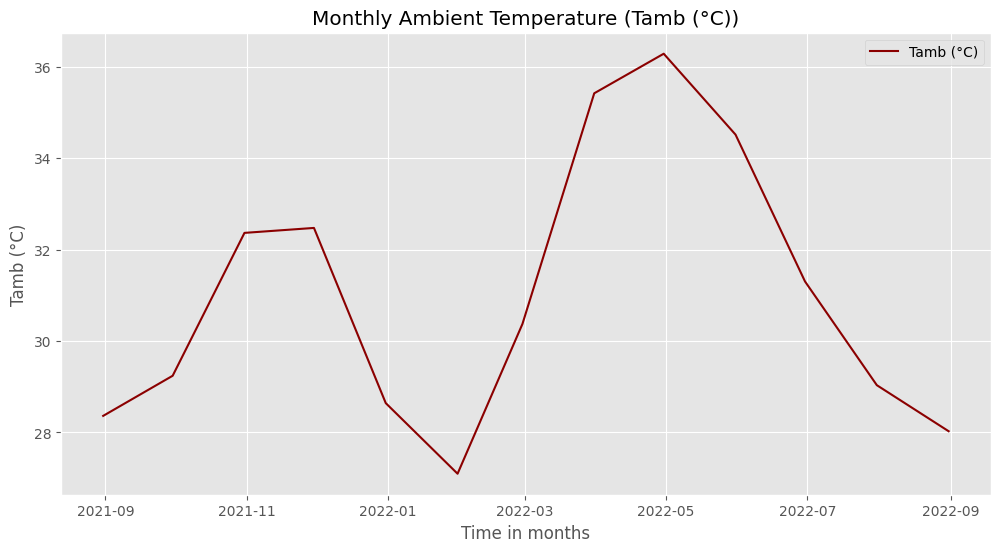

In [94]:
#Tamb over the months
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_data, x=monthly_data.index, y='Tamb', label='Tamb (°C)', color='darkred')
plt.title('Monthly Ambient Temperature (Tamb (°C))')
plt.xlabel('Time in months')
plt.ylabel('Tamb (°C)')
plt.legend()
plt.show()

In both graphs we can see the pattern through a year long period. Temprature drops and peaks can be clearly observed.

#### Feature Relationships

Correlation Analysis measures the strength of the linear relationship between two variables and computes their association.


##### Correlation Matrix of Temperature Measures and Solar Radiation

          TModA     TModB       GHI       DNI       DHI
TModA  1.000000  0.957611  0.876487  0.624479  0.605912
TModB  0.957611  1.000000  0.797738  0.579453  0.526798
GHI    0.876487  0.797738  1.000000  0.767136  0.617398
DNI    0.624479  0.579453  0.767136  1.000000  0.029839
DHI    0.605912  0.526798  0.617398  0.029839  1.000000


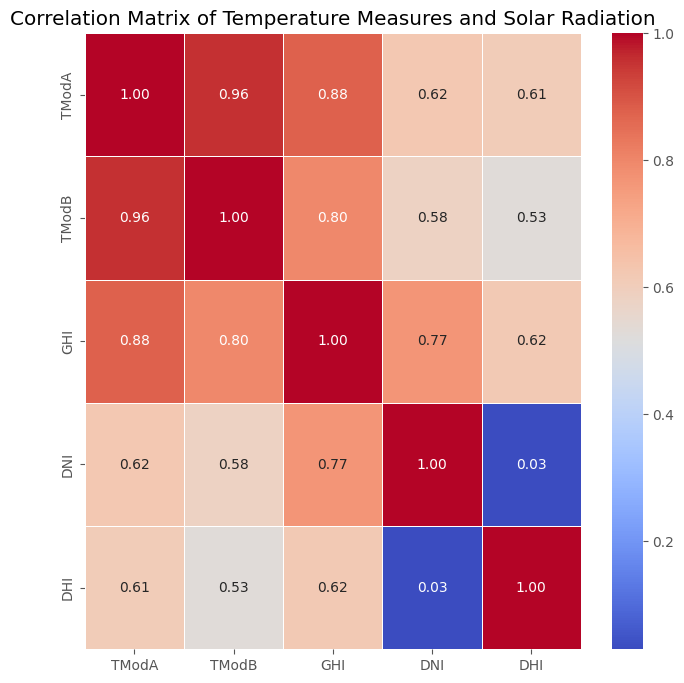

In [95]:
corr_matrix = df[['TModA', 'TModB', 'GHI', 'DNI', 'DHI']].corr()
print(corr_matrix)

plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Temperature Measures and Solar Radiation')
plt.show()

In the heat map we can observe the correlation between each data point. Through the magnitude and color of each cell. While a cooler color, blue, in this case represents weaker correlation, a warmer color denotes stronger correlation. 


#### Correlation Analysis - Wind Conditions (WS, WSgust, WD) and Solar Irradiance 

##### Correlation of Solar Radiation Measures with Wind Speed

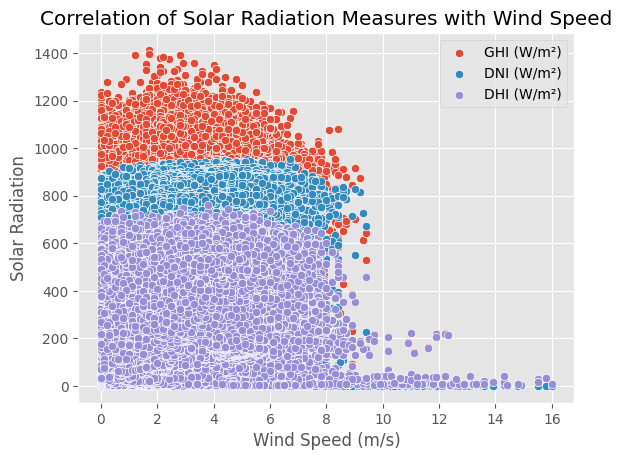

In [96]:
sns.scatterplot(data=df, x='WS', y='GHI', label='GHI (W/m²)')
sns.scatterplot(data=df, x='WS', y='DNI', label='DNI (W/m²)')
sns.scatterplot(data=df, x='WS', y='DHI', label='DHI (W/m²)')

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Solar Radiation')
plt.title('Correlation of Solar Radiation Measures with Wind Speed')


plt.show()

##### Correlation of Solar Radiation Measures with Wind Gust Speed(Wsgust)

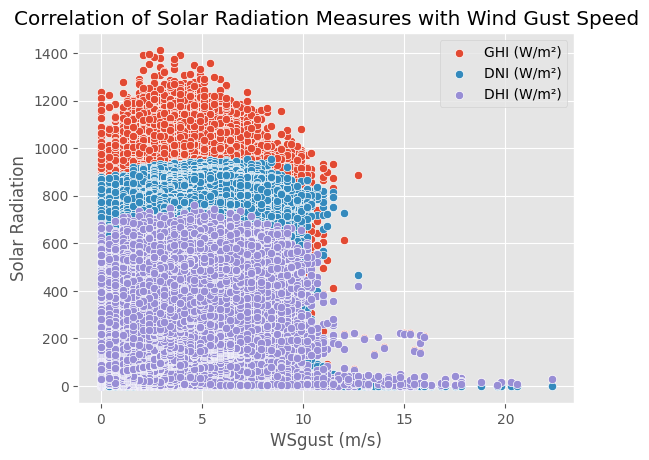

In [97]:
sns.scatterplot(data=df, x='WSgust', y='GHI', label='GHI (W/m²)')
sns.scatterplot(data=df, x='WSgust', y='DNI', label='DNI (W/m²)')
sns.scatterplot(data=df, x='WSgust', y='DHI', label='DHI (W/m²)')

plt.xlabel('WSgust (m/s)')
plt.ylabel('Solar Radiation')
plt.title('Correlation of Solar Radiation Measures with Wind Gust Speed')

plt.show()

##### Correlation of Solar Radiation Measures with Wind Direction(WD) 


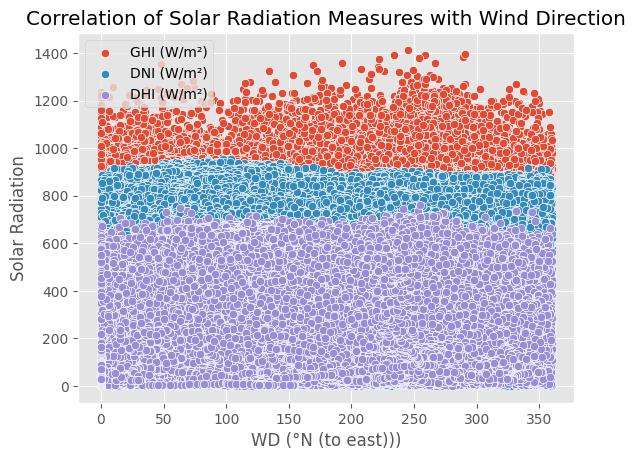

In [98]:
sns.scatterplot(data=df, x='WD', y='GHI', label='GHI (W/m²)')
sns.scatterplot(data=df, x='WD', y='DNI', label='DNI (W/m²)')
sns.scatterplot(data=df, x='WD', y='DHI', label='DHI (W/m²)')

plt.xlabel('WD (°N (to east)))')
plt.ylabel('Solar Radiation')
plt.title('Correlation of Solar Radiation Measures with Wind Direction')

plt.show()

From the previous correlation plots we can deduce that Wind conditions and Solar Irradiance don't have a linear correlation. 

#### Wind Analysis

##### Windrose - Distribution of Wind Speed and Direction

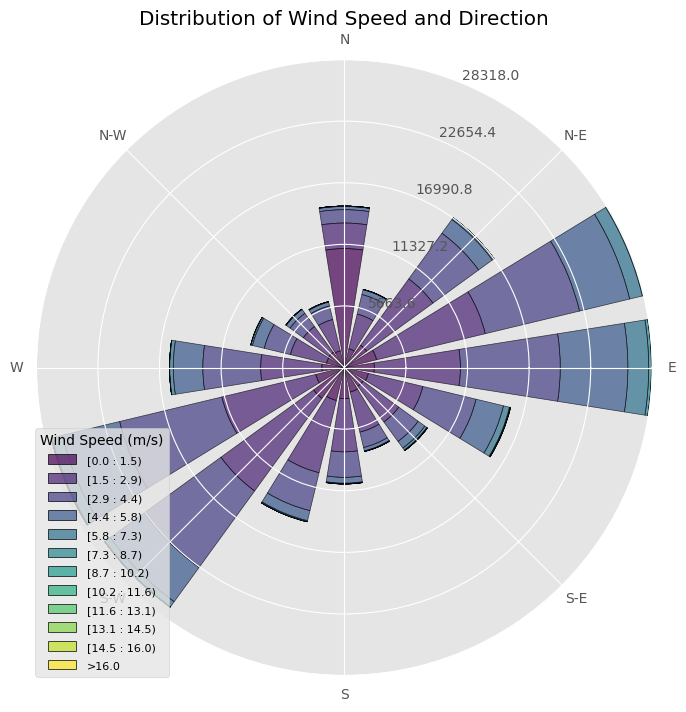

In [99]:
wind_speed = df['WS']  
wind_directions = df['WD']

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='windrose')

ax.bar(wind_directions, wind_speed, bins=12, opening=0.8, edgecolor='black', alpha=0.7)
ax.set_title("Distribution of Wind Speed and Direction")
ax.set_legend(title="Wind Speed (m/s)")

# Show the plot
plt.show()

In the previous plot we can see which directions have higher wind intensity or speed. The North East and South West directions have higher intensity.

#### Radial Bar Plot : Wind Speed and Direction Variability

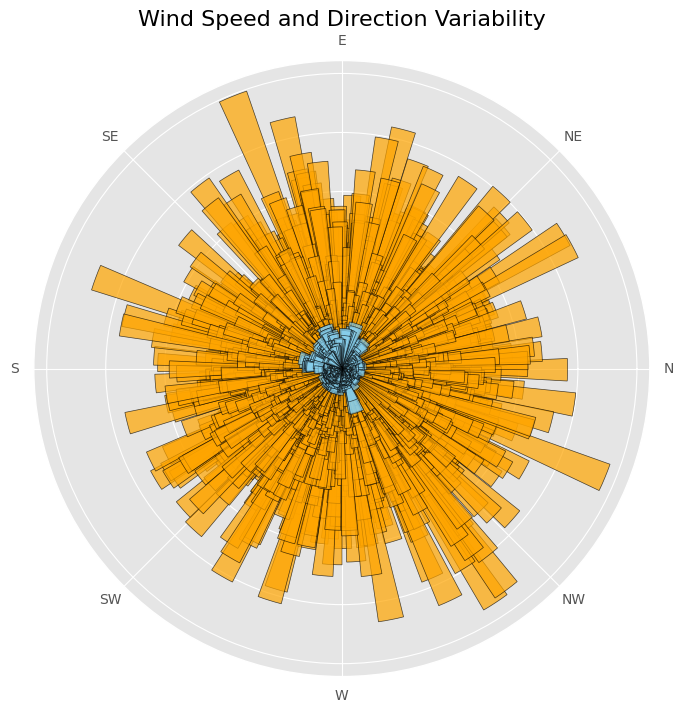

In [100]:
wind_speed = df['WS']  
wind_direction = df['WD']  
wind_direction_std = df['WDstdev']  

angles = np.radians(wind_direction)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.bar(angles, wind_direction_std, width=0.1, bottom=0.0, color='orange', edgecolor='black', alpha=0.7)
ax.bar(angles, wind_speed, width=0.3, bottom=0.0, color='skyblue', edgecolor='black', alpha=0.7)

ax.set_title('Wind Speed and Direction Variability', fontsize=16)
ax.set_yticklabels([])  
ax.set_xticks(np.radians(np.arange(0, 360, 45))) 
ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

plt.show()

#### Temprature Analysis

#### Correlation Matrix of Temperature, RH, and Solar Radiation

          Tamb        RH       GHI       DNI       DHI
Tamb  1.000000 -0.495461  0.414207  0.287826  0.296023
RH   -0.495461  1.000000 -0.311479 -0.351069 -0.137887
GHI   0.414207 -0.311479  1.000000  0.767136  0.617398
DNI   0.287826 -0.351069  0.767136  1.000000  0.029839
DHI   0.296023 -0.137887  0.617398  0.029839  1.000000


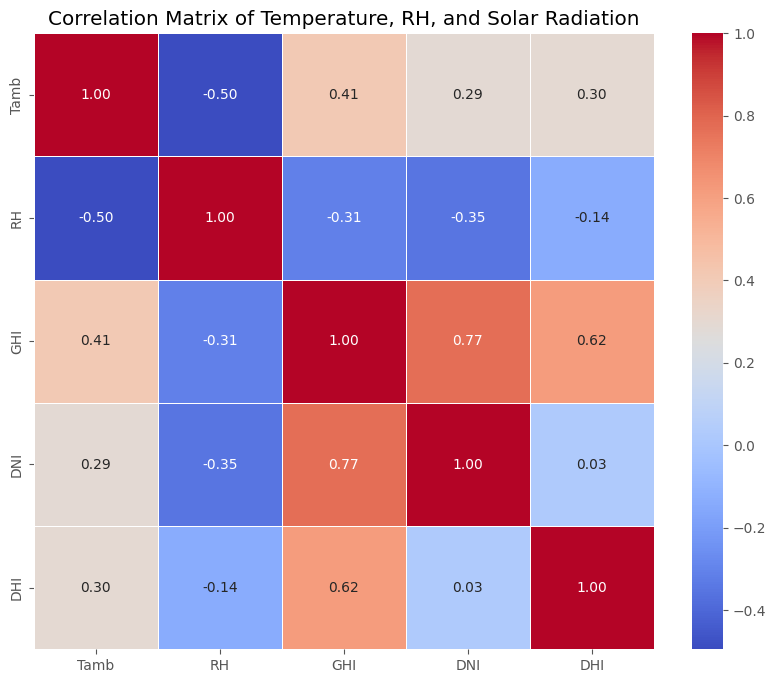

In [101]:
corr_matrix = df[['Tamb', 'RH', 'GHI', 'DNI', 'DHI']].corr()
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Temperature, RH, and Solar Radiation')
plt.show()

##### Scatter Plot - Temperature vs. Relative Humidity

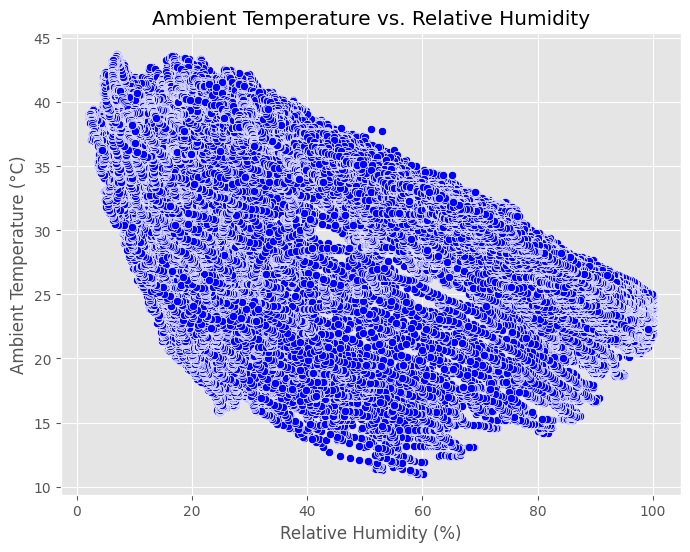

In [102]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='RH', y='Tamb', data=df, color='blue')

plt.title('Ambient Temperature vs. Relative Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')

plt.show()

Here we can see that Ambient Temperature and Relative Humidity have a negative linear correlation.

##### Scatter Plot - Global Horizontal Irradiance (GHI) vs. Relative Humidity

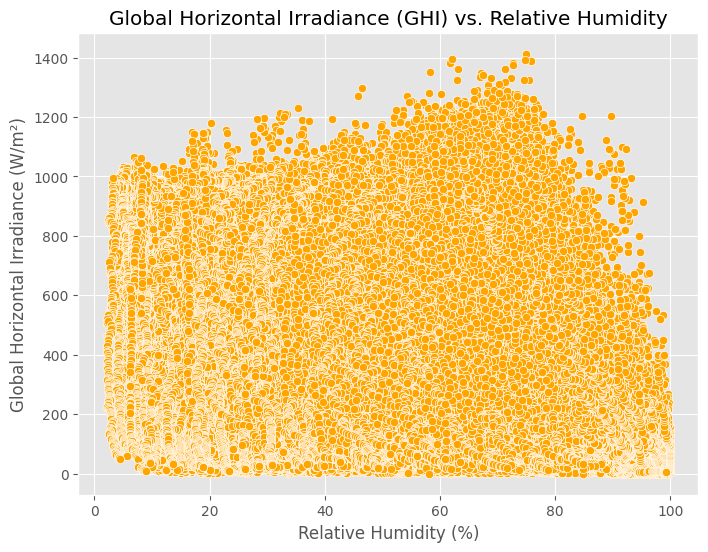

In [103]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='RH', y='GHI', data=df, color='orange')
plt.title('Global Horizontal Irradiance (GHI) vs. Relative Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.show()

##### Scatter Plot - Direct Normal Irradiance (DNI) vs. Relative Humidity

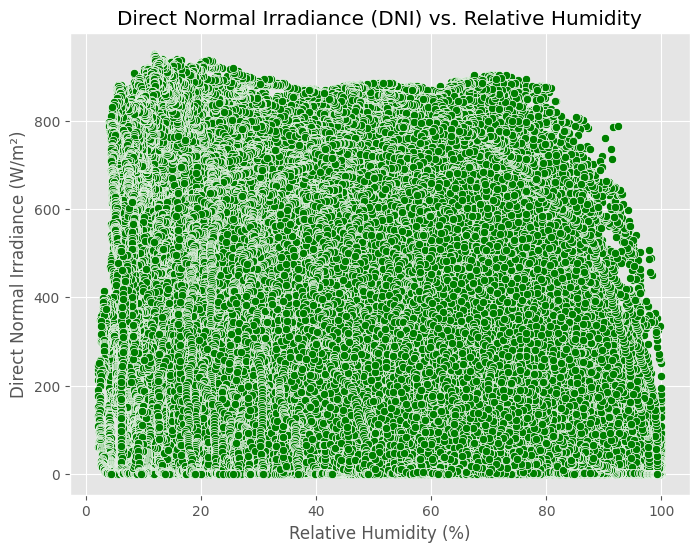

In [104]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='RH', y='DNI', data=df, color='green')
plt.title('Direct Normal Irradiance (DNI) vs. Relative Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Direct Normal Irradiance (W/m²)')
plt.show()

##### Scatter Plot - Diffuse Horizontal Irradiance (DHI) vs. Relative Humidity

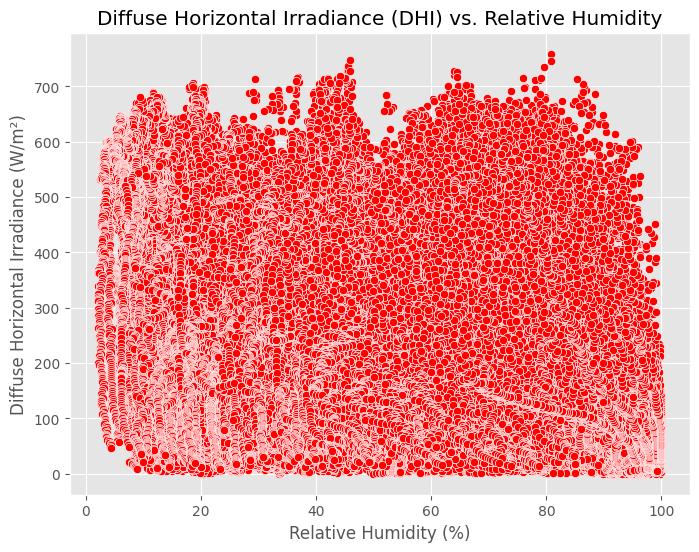

In [105]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='RH', y='DHI', data=df, color='red')

plt.title('Diffuse Horizontal Irradiance (DHI) vs. Relative Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Diffuse Horizontal Irradiance (W/m²)')

plt.show()

Relative Humidity (RH) has a non-linear relationship with Solar Radiation (DHI, DNI, GHI) measures. 

#### Bubble Chart: GHI vs. Tamb vs. RH and WS 

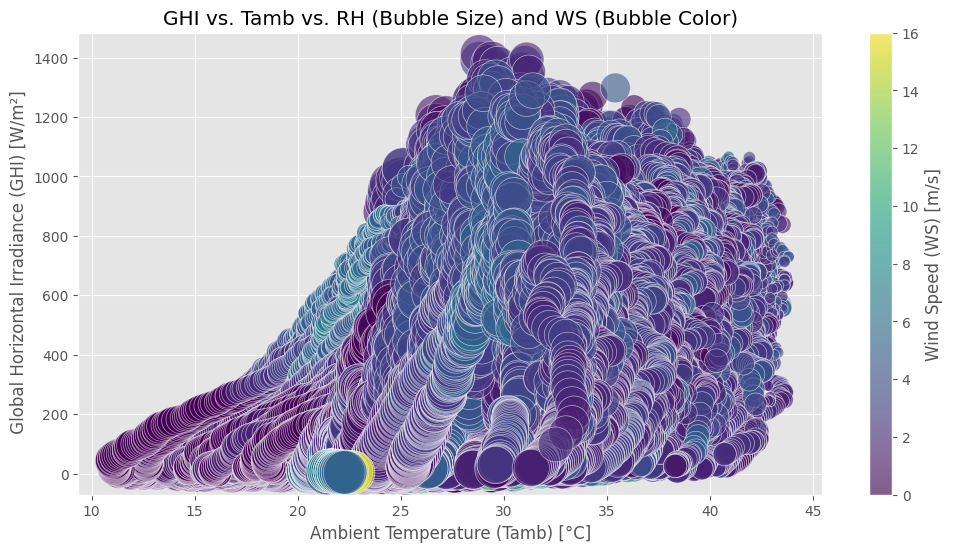

In [106]:
plt.figure(figsize=(12, 6))
plt.scatter(x=df['Tamb'],y=df['GHI'], s=df['RH'] * 10, c=df['WS'], alpha=0.6, edgecolors='w',linewidth=0.5)

plt.title('GHI vs. Tamb vs. RH (Bubble Size) and WS (Bubble Color)')
plt.xlabel('Ambient Temperature (Tamb) [°C]')
plt.ylabel(' Global Horizontal Irradiance (GHI) [W/m²]')

plt.colorbar(label='Wind Speed (WS) [m/s]')

plt.show()

GHI and Ambient Temprature(Tamb) have a linear positive correlation while RH has a negative correlation with Tamb.